<p align="center">
Universidade Federal de Alagoas</br>

Instituto de Computação</br>

</p>

#Trabalho Prático AB2

Disciplina: Sistemas Distribuídos

Semestre letivo: 2017.1

Professor: André Lage Freitas

## Especificação

**Importante**. Leia atentamente essa seção pois só serão aceitos trabalhos que obedecerem as a especificações a seguir. 

Baseado(a) no exemplo a seguir de implementação do B-multicast em Julia, façam os exercícios descritos nesse documento.

# B_multicast

In [1]:
using Distributed
using Plots
using StatsPlots

function mean(array)
    return(sum(array) / length(array))
end

function std(array)
    s, m = 0, mean(array)
    for x in array
        s += (x - m)*(x - m)
    end
    return(sqrt(s / (length(array) - 1)))
end

std (generic function with 1 method)

In [2]:
z, iterations = 1.96, 50
addprocs(10)
group = workers()

10-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

In [3]:
@everywhere function B_deliver(message)
#     println(message)
#     flush(stdout)
    sleep(0.01)
end

function B_sync_multicast(group, message, B_deliver)
    for i in group
        @sync @spawnat i B_deliver(message)
    end
end

function B_async_multicast(group, message, B_deliver)
    @sync for i in group
        @spawnat i B_deliver(message)
    end
end

B_async_multicast (generic function with 1 method)

In [4]:
syncTimes = []
for i in 1:iterations
    println("$i -----------------------------------")
    flush(stdout)
    push!(syncTimes, @elapsed B_sync_multicast(group, "Sync hi  -- $i", B_deliver))
end

1 -----------------------------------
2 -----------------------------------
3 -----------------------------------
4 -----------------------------------
5 -----------------------------------
6 -----------------------------------
7 -----------------------------------
8 -----------------------------------
9 -----------------------------------
10 -----------------------------------
11 -----------------------------------
12 -----------------------------------
13 -----------------------------------
14 -----------------------------------
15 -----------------------------------
16 -----------------------------------
17 -----------------------------------
18 -----------------------------------
19 -----------------------------------
20 -----------------------------------
21 -----------------------------------
22 -----------------------------------
23 -----------------------------------
24 -----------------------------------
25 -----------------------------------
26 -------------------------------

In [5]:
asyncTimes = []
asyncTotalTime = for i in 1:iterations
    println("$i -----------------------------------")
    flush(stdout)
    push!(asyncTimes, @elapsed B_async_multicast(group, "Async hi -- $i", B_deliver))
end

1 -----------------------------------
2 -----------------------------------
3 -----------------------------------
4 -----------------------------------
5 -----------------------------------
6 -----------------------------------
7 -----------------------------------
8 -----------------------------------
9 -----------------------------------
10 -----------------------------------
11 -----------------------------------
12 -----------------------------------
13 -----------------------------------
14 -----------------------------------
15 -----------------------------------
16 -----------------------------------
17 -----------------------------------
18 -----------------------------------
19 -----------------------------------
20 -----------------------------------
21 -----------------------------------
22 -----------------------------------
23 -----------------------------------
24 -----------------------------------
25 -----------------------------------
26 -------------------------------

Sync total time: 4.5965297 || Async total time: 0.5757004010000001
Sync mean time: 0.11785973589743588 || Async mean time: 0.014761548743589746
Sync std time: 0.0020548987219232953 || Async std time: 0.0006428849544610654
Sync: [0.113892, 0.114971, 0.114997, 0.115255, 0.11563, 0.115642, 0.115643, 0.115884, 0.115947, 0.115954, 0.115988, 0.116195, 0.11661, 0.11668, 0.117083, 0.117084, 0.117281, 0.117289, 0.117611, 0.117784, 0.117897, 0.118259, 0.118496, 0.118677, 0.118831, 0.118877, 0.119077, 0.119166, 0.119273, 0.11939, 0.119472, 0.119911, 0.120021, 0.1201, 0.120239, 0.120529, 0.120943, 0.121348, 0.122606]
Async: [0.0133477, 0.0135184, 0.013619, 0.0137275, 0.0138727, 0.0138834, 0.0142417, 0.0142479, 0.0143166, 0.0143324, 0.0143602, 0.0144024, 0.0144122, 0.0144196, 0.0146159, 0.0146463, 0.0147062, 0.0147099, 0.0147854, 0.0148639, 0.0148731, 0.0148808, 0.0148957, 0.0149799, 0.015036, 0.0151999, 0.0152274, 0.0152329, 0.0152578, 0.0154044, 0.0154134, 0.0154192, 0.0154598, 0.0154612, 0.01547

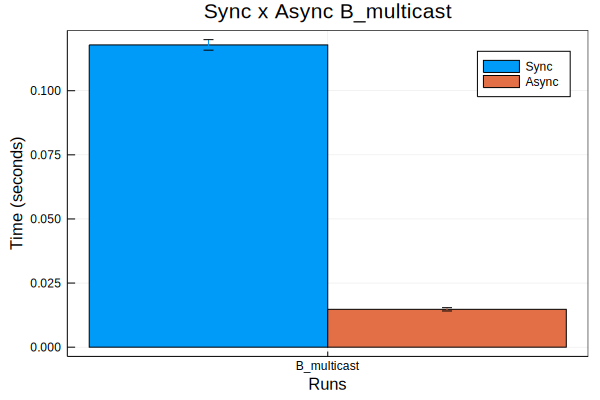

In [6]:
syncTimes, asyncTimes = Array{Float64}(syncTimes), Array{Float64}(asyncTimes)
sort!(syncTimes), sort!(asyncTimes)
deleteat!(syncTimes, UnitRange(length(syncTimes) - 10, length(syncTimes)))
deleteat!(asyncTimes, UnitRange(length(asyncTimes) - 10, length(asyncTimes)))
syncTotalTime, asyncTotalTime = sum(syncTimes), sum(asyncTimes)
syncMeanTime, asyncMeanTime = mean(syncTimes), mean(asyncTimes)
syncStdTime, asyncStdTime = std(syncTimes), std(asyncTimes)

println("Sync total time: $syncTotalTime || Async total time: $asyncTotalTime")
println("Sync mean time: $syncMeanTime || Async mean time: $asyncMeanTime")
println("Sync std time: $syncStdTime || Async std time: $asyncStdTime")
println("Sync: $syncTimes")
println("Async: $asyncTimes")

# plot(1:length(syncTimes),
#          [syncTimes, asyncTimes],
#          title="Sync x Async B_multicast",
#          label=["Sync", "Async"],
#          xlabel="Runs",
#          ylabel="Time (s)")
groupedbar(
           ["B_multicast"],
           [syncMeanTime asyncMeanTime],
           yerr = [syncStdTime asyncStdTime],
           label = ["Sync", "Async"],
           xlabel = "Runs",
           ylabel = "Time (seconds)",
           title = "Sync x Async B_multicast",
           framestyle = :box)

# --------------------------------------------------------------------------------------------------------------
# R_multicast

In [7]:
z, iterations = 1.96, 50
rmprocs(workers())
addprocs(10)
group = workers()

10-element Array{Int64,1}:
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21

In [8]:
counter = 0

@everywhere function B_sync_deliver(group, from, message)
    global received
#     println(message)
#     flush(stdout)
#     sleep(0.01)
    
    if !(from in received)
        push!(received, from)
        if from != myid()
            B_sync_multicast(group, message, B_sync_deliver)
        end
        sleep(0.01)
    end
    @spawnat 1 global counter += 1
end

@everywhere function B_sync_multicast(group, message, B_deliver)
    my_id = myid()
    for i in group
        @sync @spawnat i B_sync_deliver(group, my_id, message)
    end
end

function R_sync_multicast(group, message)
    @everywhere group global received = Set()

    for i in group
        @sync @spawnat i B_sync_multicast(group, message, B_sync_deliver)
    end
end
    
@everywhere function B_async_deliver(group, from, message)
    global received
#     println(message)
#     flush(stdout)
#     sleep(0.01)
    
    if !(from in received)
        push!(received, from)
        if (from != myid())
            B_async_multicast(group, message, B_async_deliver)
        end
        sleep(0.01)
    end
end

@everywhere function B_async_multicast(group, message, B_deliver)
    my_id = myid()
    @sync for i in group
        @spawnat i B_async_deliver(my_id, message)
    end
end

function R_async_multicast(group, message)
    @everywhere group global received = Set()

    @sync for i in group
        @spawnat i B_sync_multicast(group, message, B_sync_deliver)
    end
end

R_async_multicast (generic function with 1 method)

In [9]:
syncTimes = []
for i in 1:iterations
    println("$i -----------------------------------")
    flush(stdout)
    push!(syncTimes, @elapsed R_sync_multicast(group, "Sync hi  -- $i"))
    if i == 1
        println(counter)
    end
end

1 -----------------------------------
1000
2 -----------------------------------
3 -----------------------------------
4 -----------------------------------
5 -----------------------------------
6 -----------------------------------
7 -----------------------------------
8 -----------------------------------
9 -----------------------------------
10 -----------------------------------
11 -----------------------------------
12 -----------------------------------
13 -----------------------------------
14 -----------------------------------
15 -----------------------------------
16 -----------------------------------
17 -----------------------------------
18 -----------------------------------
19 -----------------------------------
20 -----------------------------------
21 -----------------------------------
22 -----------------------------------
23 -----------------------------------
24 -----------------------------------
25 -----------------------------------
26 --------------------------

In [10]:
asyncTimes = []
asyncTotalTime = for i in 1:iterations
    println("$i -----------------------------------")
    flush(stdout)
    push!(asyncTimes, @elapsed R_async_multicast(group, "Async hi -- $i"))
end

1 -----------------------------------
2 -----------------------------------
3 -----------------------------------
4 -----------------------------------
5 -----------------------------------
6 -----------------------------------
7 -----------------------------------
8 -----------------------------------
9 -----------------------------------
10 -----------------------------------
11 -----------------------------------
12 -----------------------------------
13 -----------------------------------
14 -----------------------------------
15 -----------------------------------
16 -----------------------------------
17 -----------------------------------
18 -----------------------------------
19 -----------------------------------
20 -----------------------------------
21 -----------------------------------
22 -----------------------------------
23 -----------------------------------
24 -----------------------------------
25 -----------------------------------
26 -------------------------------

Sync total time: 67.672730703 || Async total time: 9.646665005
Sync mean time: 1.735198223153846 || Async mean time: 0.24735038474358972
Sync std time: 0.15166095484072684 || Async std time: 0.008414151415840947
Sync: [1.46244, 1.46503, 1.47778, 1.49502, 1.51681, 1.54337, 1.5434, 1.5535, 1.58304, 1.607, 1.61487, 1.64479, 1.66777, 1.66792, 1.70769, 1.71959, 1.72301, 1.73529, 1.75339, 1.76042, 1.76995, 1.77301, 1.79257, 1.79394, 1.81988, 1.82193, 1.85511, 1.86523, 1.86806, 1.87474, 1.88096, 1.88975, 1.89069, 1.89861, 1.90863, 1.9098, 1.916, 1.94058, 1.96113]
Async: [0.229124, 0.235079, 0.235279, 0.235365, 0.235922, 0.239415, 0.240207, 0.240905, 0.241751, 0.242517, 0.242703, 0.242788, 0.242822, 0.242983, 0.244442, 0.244959, 0.245437, 0.246252, 0.247171, 0.247468, 0.247917, 0.248253, 0.248488, 0.248613, 0.248902, 0.249453, 0.24963, 0.249647, 0.250552, 0.252816, 0.253225, 0.253317, 0.254698, 0.255461, 0.257324, 0.260865, 0.26247, 0.265259, 0.267186]


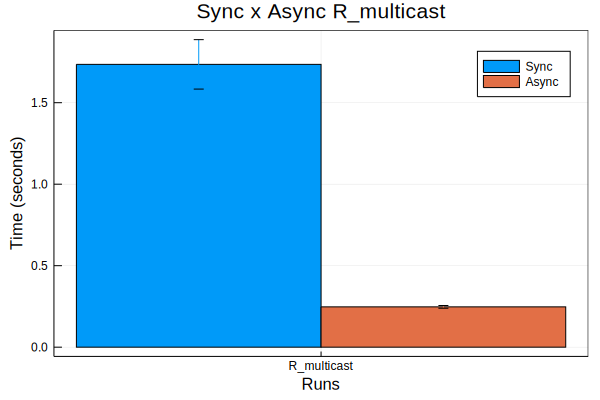

In [11]:
syncTimes, asyncTimes = Array{Float64}(syncTimes), Array{Float64}(asyncTimes)
sort!(syncTimes), sort!(asyncTimes)
deleteat!(syncTimes, UnitRange(length(syncTimes) - 10, length(syncTimes)))
deleteat!(asyncTimes, UnitRange(length(asyncTimes) - 10, length(asyncTimes)))
syncTotalTime, asyncTotalTime = sum(syncTimes), sum(asyncTimes)
syncMeanTime, asyncMeanTime = mean(syncTimes), mean(asyncTimes)
syncStdTime, asyncStdTime = std(syncTimes), std(asyncTimes)

println("Sync total time: $syncTotalTime || Async total time: $asyncTotalTime")
println("Sync mean time: $syncMeanTime || Async mean time: $asyncMeanTime")
println("Sync std time: $syncStdTime || Async std time: $asyncStdTime")
println("Sync: $syncTimes")
println("Async: $asyncTimes")

# plot(1:length(syncTimes),
#          [syncTimes, asyncTimes],
#          title="Sync x Async B_multicast",
#          label=["Sync", "Async"],
#          xlabel="Runs",
#          ylabel="Time (s)")
groupedbar(
           ["R_multicast"],
           [syncMeanTime asyncMeanTime],
           yerr = [syncStdTime asyncStdTime],
           label = ["Sync", "Async"],
           xlabel = "Runs",
           ylabel = "Time (seconds)",
           title = "Sync x Async R_multicast",
           framestyle = :box)

In [12]:
# function B_multicast(g,m,B_deliver)
#    for p in g
#        remotecall(p, B_deliver, m)
#    end
# end

# Adding 3 processes (workers)
#addprocs(3)

# My group is composed by all workers
# g = workers()

# Multicasting "oi!" message to group `g` by assuming `println` as B_deliver function.
# B_multicast(g,"oi!",println)

### Exercício 1: Sincronismo (2,0 pontos)

Adicione 10 processos com o comando `addprocs` abaixo. 

_Atenção_: sua instalação local de Julia pode não conseguir adicionar 10 processos, use a [JuliaBox](https://juliabox.com).

In [13]:
# addprocs(10)

Modifique a implementação do B-multicast para utilizar communicação síncrona.

In [14]:
#TODO implementação do B-multicast síncrono.

Execute as duas versões do B-multicast (síncrona e assíncrona) e compare as saídas.

A ordem das mensagens das saídas foram as mesmas para ambas versões do B-multicast? Por quê?

**Resposta**: _em itálico_



### Exercício 2: Análise de desempenho do B-multicast (2,0 pontos)

Meça o tempo de execução duas versões do B-multicast (síncrona e assíncrona). Dica: utilize a macro `@time`.

* Execute 50 vezes essa medição e construa um gráfico em forma de barras:
	* cada barra representando cada versão do B-multicast;
	* calcule e coloque no gráfico o [intervalo de confiança](https://en.wikipedia.org/wiki/Confidence_interval) com nível de 95%.
    
**Gráfico**: _por aqui_    
    
    
* Qual das duas versões teve o menor tempo de execução? Por quê?

**Resposta**: _em itálico_



### Exercício 3: Análise de desempenho do R-multicast (3,0 pontos)

Implemente duas versões do algoritmo R-multicast: uma assíncrona e outra síncrona.

* R-multicast assíncrono

In [15]:
#TODO implementação do R-multicast síncrono.

* R-multicast assíncrono

In [16]:
#TODO implementação do R-multicast assíncrono.

Faça a mesma análise de desempenho para o R-multicast que você fez no Exercício 2.


**Gráfico**: _por aqui_    
    
    
* Qual das duas versões (R-multicast assíncrono e assíncrono) teve o menor tempo de execução? Por quê?

**Resposta**: _em itálico_



### Exercício 4: Análise de desempenho: B-multicast vs. R-multicast (3,0 pontos)

Para cada uma das comparações abaixo, qual dos algoritmos teve o menor tempo de execução? Por quê?

* B-multicast assíncrono vs. R-multicast assíncrono.
    

**Resposta**: _em itálico_    
    
* B-multicast síncrono vs. R-multicast síncrono.


**Resposta**: _em itálico_

## Entrega

As respostas deverão ser entregues nos devidos campos desse arquivo, ou seja, em [Markdown](https://en.wikipedia.org/wiki/Markdown) e no formato [IJulia Notebook](https://github.com/JuliaLang/IJulia.jl).

O programa deve ser implementado na linguagem de programação **Julia**. Seu trabalho será testado na [JuliaBox](https://juliabox.com), portanto teste seu arquivo IJulia na JulizBox antes de enviá-lo.


### Forma 

O arquivo IJulia Notebook deverá ser entregue ao Professor **exclusivamente através do Google Classroom**.



A responsabilidade sobre a integridade do arquivo contendo trabalho é exclusivamente dos discentes. Serão ignorados os trabalhos cujos arquivos não conseguirem ser abertos pelo Professor.

### Prazos

O prazo de entrega sem atraso é o dia **18/11/17**.

Trabalhos entregues com atraso serão aceitos, no máximo, até o o dia **19/11/17**. Serão descontados 5% da nota obtida por dia de atraso.


## Pontuação extra

O(a) discente que realizar mais tarefas, além do que foi especificado neste trabalho, o professor atribuirá de 0,5 a 1,0 ponto extra a depender da relevância da contribuição no programa. O critério será decidido pelo professor. 

O(a) discente deve indicar qual é a tarefa executada. Por exemplo, adição de funcionalidades, armazenamento de dados em arquivo, documentação de código, comentários em inglês sem erros ortográficos, etc.


**Plágio** A nota zero será atribuída caso haja qualquer tipo de cópia parcial ou integral assim como as devidas medidas legais. Leia a [cartilha sobre plágio](http://www.noticias.uff.br/arquivos/cartilha-sobre-plagio-academico.pdf).

## Disclaimer

Esse material foi elaborado pelo [Prof. André Lage Freitas](https://sites.google.com/a/ic.ufal.br/andrelage/) e está licenciado sob a licença _GNU General Public License v3.0_.